# DS 3001: Voting Project - Michelle Kim and Cara Seely

## Summary
This project looks to analyze voting patterns in Virginia from historical election data, aiming to uncover patterns and predict future outcomes. By looking into data on voting by candidate and party, with geographical information, we seek to explore voter preferences, election results and predict the outcomes of the 2024 election. In this project, we look to answer the question of how election results in Virginia have changed over time and how results will look in future elections. Our project utilizes numerous datasets and csv files, including county, county adjacencies, and voting in Virginia data. These datasets were cleaned before conducting analysis, which is discussed later in this paper. After cleaning, the variables within the data were analyzed through visualizations. The variables being used in this analysis include county FIP codes, total votes, candidates, and political party. These are key variables that will be the most effective in giving insights about voting in Virginia. With the help of these visualizations, our project then aims to predict the election results of Virginia in 2024. Our projected results show that the Democratic party votes will continue to be the highest, but that the Republican party will also have a substantial amount of votes. 

## Data
This part of the paper is dedicated to explaining the data and key variables of the analysis, including the data cleaning that was conducted in this project. Data cleaning is an essential first step in data analysis and helped to ensure that our datasets were consistent. Before cleaning, we imported necessary libraries and read in the csv files. Our datasets primarily consist of historical voting data for Virginia. Key variables include, ‘year,’ ‘county name’, ‘candidate’, ‘party’, ‘candidate votes’, and ‘total votes,’ which provide information about electoral trends over the years.

In [1]:
! git clone https://github.com/michellehkim280/project_voting

fatal: destination path 'project_voting' already exists and is not an empty directory.


In [2]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade --force-reinstall pandas

  Using cached pandas-2.2.2-cp39-cp39-macosx_10_9_x86_64.whl (12.6 MB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2024.1
    Uninstalling tzdata-2024.1:
      Successfully uninstalled tzdata-2024.1
  Attempting uninstall: pytz
    Found existing installation: pytz 2024.1
    Uninstalling pytz-2024.1:
      Successfully uninstalled pytz-2024.1
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uni

In [5]:
# Importing Packages
import geopandas as gpd
#import mapclassify
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
import zipfile
import os

# Loading Data 
vdf = pd.read_csv('project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

Reading the numerous county_data csv files was troubling because we had to conduct the same loading and cleaning for each, and figure out how to save it all to one dataframe. We used a for loop that iterates over our list of files and stores them all in one array. After loading in the multiple csv files, we cleaned them by first standardizing the FIPS codes. This ensures that any column named ‘FIPS’ or ‘county_fips’ contains a string that is 5 characters, giving us consistency across data sets. An always significant challenge with any project involving data is dealing with missing values and outliers that could potentially skew the analysis. For this dataset, we decided to fill in missing values with the median of the column. We went through this strategy to maintain the integrity of the dataset, rather than entirely removing it. Removing entire rows with missing values could result in losing potentially good data and reduce the power of our statistical analysis. Our approach was also similarly done with categorical columns, as we fill in missing values with the most of each column. However, we removed any rows that are missing the FIPS code because it is critical in identifying counties or states. Without the FIPS code, our geographical data would be incomplete. 

In [9]:
# Loading and Cleaning county_data

def load_data(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')

def prepare_data(df):
    # Standardize FIPS codes
    fips_columns = [col for col in ['FIPS', 'county_fips'] if col in df.columns]
    for col in fips_columns:
        df[col] = df[col].astype(str).str.zfill(5)

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Unneeded1', 'Unneeded2'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill numeric columns with the median
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical columns with the mode (most frequent value)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Remove rows with missing FIPS codes if critical
    df.dropna(subset=fips_columns, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df

# Directory to save cleaned files
output_directory = 'project_voting/data/county_data/cleaned'
os.makedirs(output_directory, exist_ok=True)

# Paths to the county data files
files = [
    'project_voting/data/county_data/0002_ds176_20105_county_E.csv',
    'project_voting/data/county_data/0002_ds177_20105_county_E.csv',
    'project_voting/data/county_data/0002_ds191_20125_county_E.csv',
    'project_voting/data/county_data/0002_ds206_20145_county_E.csv',
    'project_voting/data/county_data/0002_ds225_20165_county_E.csv',
    'project_voting/data/county_data/0002_ds239_20185_county_E.csv',
    'project_voting/data/county_data/0002_ds249_20205_county_E.csv',
    'project_voting/data/county_data/0002_ds250_20205_county_E.csv'
]

# Load, clean, and save each file
for file_path in files:
    df = load_data(file_path)
    cleaned_df = prepare_data(df)
    cleaned_file_path = os.path.join(output_directory, os.path.basename(file_path).replace('.csv', '_cleaned.csv'))
    cleaned_df.to_csv(cleaned_file_path, index=False)
     

/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_24130/200925752.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_24130/200925752.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

For the voting_va csv file, we once again standardized the FIPS codes, in addition to certain columns. We choose to remove rows that were missing critical information in columns like ‘county_fips’, ‘candidatevotes’, or ‘totalvotes’ because these values are essential for analyzing voting patterns and outcomes. Overall, all of these cleaning steps were necessary to ensure that our data quality is consistent and reliable, enabling us to create better insights. 

In [11]:
# Cleaning vdf (historical voting data)
# Standardize FIPS codes to ensure they are five characters long, zero-padded
vdf['county_fips'] = vdf['county_fips'].astype(str).str.zfill(5)

# Remove any rows where critical information is missing
vdf.dropna(subset=['county_fips', 'candidatevotes', 'totalvotes'], inplace=True)

# Convert vote counts to integers (in case they are not)
vdf['candidatevotes'] = vdf['candidatevotes'].astype(int)
vdf['totalvotes'] = vdf['totalvotes'].astype(int)

# Check for any duplicates and remove them
vdf.drop_duplicates(inplace=True)

# Convert certain columns with usable data to lower case for ease
vdf['county_name'] = vdf['county_name'].str.lower()
vdf['candidate'] = vdf['candidate'].str.lower()
vdf['party'] = vdf['party'].str.lower()


In [13]:
print(cdf)

               County  Population2022   FIPS  District                   N1  \
0            Accomack           33191  51001         2       Northumberland   
1           Albemarle          114534  51003         5  CharlottesvilleCity   
2      AlexandriaCity          155525  51510         8              Fairfax   
3           Alleghany           14835  51005         6                Craig   
4              Amelia           13455  51007         5         PrinceEdward   
..                ...             ...    ...       ...                  ...   
128    WinchesterCity           27936  51840         6            Frederick   
129              Wise           35421  51195         9                  Lee   
130             Wythe           28111  51197         9                Bland   
131              York           71341  51199         1           Gloucester   
132  WilliamsburgCity           15920  51830         1             JamesCty   

             N2                N3               N4 

In [14]:
print(vdf)

      Unnamed: 0  year     state state_po      county_name county_fips  \
0          11161  2000  VIRGINIA       VA         accomack       51001   
1          11162  2000  VIRGINIA       VA         accomack       51001   
2          11163  2000  VIRGINIA       VA         accomack       51001   
3          11164  2000  VIRGINIA       VA         accomack       51001   
4          11165  2000  VIRGINIA       VA        albemarle       51003   
...          ...   ...       ...      ...              ...         ...   
3731       71966  2020  VIRGINIA       VA  winchester city       51840   
3732       71967  2020  VIRGINIA       VA  winchester city       51840   
3733       71968  2020  VIRGINIA       VA  winchester city       51840   
3734       71969  2020  VIRGINIA       VA  winchester city       51840   
3735       71970  2020  VIRGINIA       VA  winchester city       51840   

            office       candidate       party  candidatevotes  totalvotes  \
0     US PRESIDENT         al gor

In [15]:
print(df)

      Unnamed: 0              GISJOIN            YEAR  \
0              1  GIS Join Match Code  Data File Year   
1              2             G0100010       2016-2020   
2              3             G0100030       2016-2020   
3              4             G0100050       2016-2020   
4              5             G0100070       2016-2020   
...          ...                  ...             ...   
3217        3218             G7201450       2016-2020   
3218        3219             G7201470       2016-2020   
3219        3220             G7201490       2016-2020   
3220        3221             G7201510       2016-2020   
3221        3222             G7201530       2016-2020   

                         STUSAB      REGIONA      DIVISIONA        STATE  \
0     State Postal Abbreviation  Region Code  Division Code   State Name   
1                            AL          nan            nan      Alabama   
2                            AL          nan            nan      Alabama   
3          

In [16]:
cdf['FIPS'] = cdf['FIPS'].astype(str)
df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS', how='inner')
print(df)

      Unnamed: 0  year     state state_po      county_name county_fips  \
0          11161  2000  VIRGINIA       VA         accomack       51001   
1          11162  2000  VIRGINIA       VA         accomack       51001   
2          11163  2000  VIRGINIA       VA         accomack       51001   
3          11164  2000  VIRGINIA       VA         accomack       51001   
4          11165  2000  VIRGINIA       VA        albemarle       51003   
...          ...   ...       ...      ...              ...         ...   
3715       71966  2020  VIRGINIA       VA  winchester city       51840   
3716       71967  2020  VIRGINIA       VA  winchester city       51840   
3717       71968  2020  VIRGINIA       VA  winchester city       51840   
3718       71969  2020  VIRGINIA       VA  winchester city       51840   
3719       71970  2020  VIRGINIA       VA  winchester city       51840   

            office       candidate       party  candidatevotes  ...  \
0     US PRESIDENT         al gore    de

## Results
Before making any predictions, we wanted to first analyze historical data and gain an understanding of voting in Virginia. We began by creating bar graphs displaying the total candidate votes for presidential candidates in the United States from each election in 2000-2020. To create the graphs, we selected only relevant columns from the voting_va dataframe (vdf) and filtered the data frame for the election year, ensuring that the analysis only focuses on that one election cycle. The code then aggregates the total votes for each candidate using ‘groupby’ on the column, ‘candidate’ and then adding up ‘candiddatevotes.’ This gives us the total votes for each candidate that they received in the designated election from Virginia. We used specific colors for different parties, so red for the Republican Party, blue for the Democratic Party, etc. This was to give a visual distinction between candidates and to allow for better comprehension of the graph.  




In [18]:
vdf_filtered = vdf[['candidate', 'party', 'candidatevotes', 'year', 'county_name']]

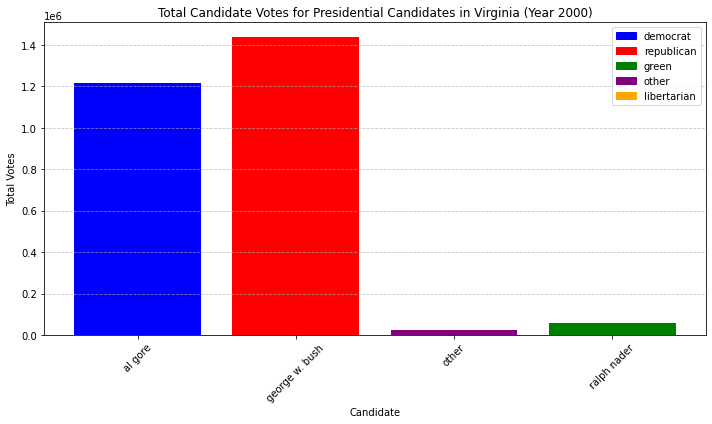

In [19]:
# 2000: Filter the DataFrame for the election year
vdf_2000 = vdf_filtered[vdf_filtered['year'] == 2000]
total_candidate_votes = vdf_2000.groupby('candidate')['candidatevotes'].sum()
#print(total_candidate_votes)
#print(vdf_2000)

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2000)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar graph above illustrates the total candidate votes for presidential candidates in Virginia for the year 2000. It vividly highlights the dominance of the two major parties, with Al Gore of the Democrats and George W. Bush of the Republicans capturing the vast majority of votes. The republican candidate only slightly had more votes compared to the democrat. 

In [69]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2000
vdf_2000 = vdf_filtered[vdf_filtered['year'] == 2000]

# Summing up votes per candidate
total_candidate_votes = vdf_2000.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2000 data
candidate_to_party = vdf_2000.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

        candidate  Total Votes       Party
0         al gore      1216422    democrat
1  george w. bush      1436877  republican
2           other        25243       other
3     ralph nader        59373       green


We also feel it's important to further analyze the data in tables because they condense complex data into an format that is easy to read and understand. We can see that Bush only won by 200,000 votes, further showing that he did not win by a substantial amount. 

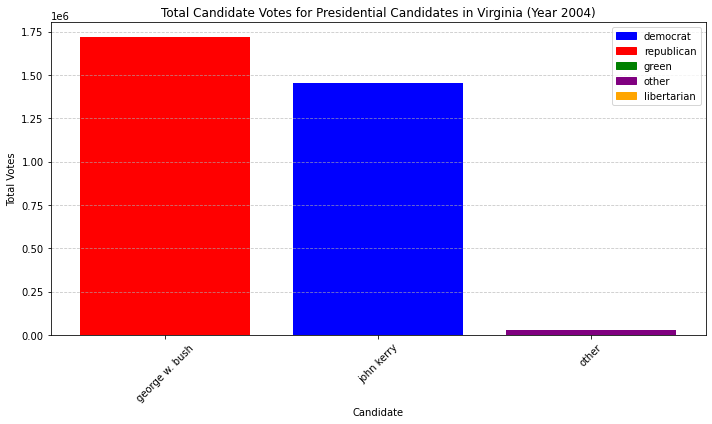

In [20]:
# 2004: Filter the DataFrame for the election year
vdf_2004 = vdf_filtered[vdf_filtered['year'] == 2004]
total_candidate_votes = vdf_2004.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2004)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2004
vdf_2004 = vdf_filtered[vdf_filtered['year'] == 2004]

# Summing up votes per candidate
total_candidate_votes = vdf_2004.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2004 data
candidate_to_party = vdf_2004.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

        candidate  Total Votes       Party
0  george w. bush      1716959  republican
1      john kerry      1454742    democrat
2           other        26666       other


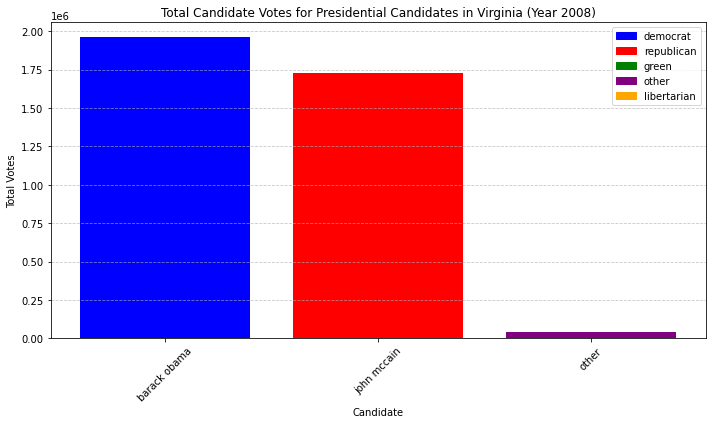

In [75]:
# 2008: Filter the DataFrame for the election year
vdf_2008 = vdf_filtered[vdf_filtered['year'] == 2008]
total_candidate_votes = vdf_2008.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2008)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This is the first graph of our project where the Democratic Party recieved the most votes. The graph clearly demonstrates that the vast majority of votes were once again taken by the two major parties: Democrats and Republicans. Barack Obama (Democrat) and John McCain (Republican) received almost all of the votes, with Obama leading significantly in Virginia. Barack Obama’s lead over John McCain is visually significant. This might potentially reflect broader national trends or specific local factors that led more voters towards Obama.

In [81]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2008
vdf_2008 = vdf_filtered[vdf_filtered['year'] == 2008]

# Summing up votes per candidate
total_candidate_votes = vdf_2008.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2008 data
candidate_to_party = vdf_2008.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

      candidate  Total Votes       Party
0  barack obama      1959532    democrat
1   john mccain      1725005  republican
2         other        38723       other


This table shows Obama's quite decisive win and a large margin between his total votes with McCain's. In addition, this table goes to shows the highest voter turnout than ever before. 

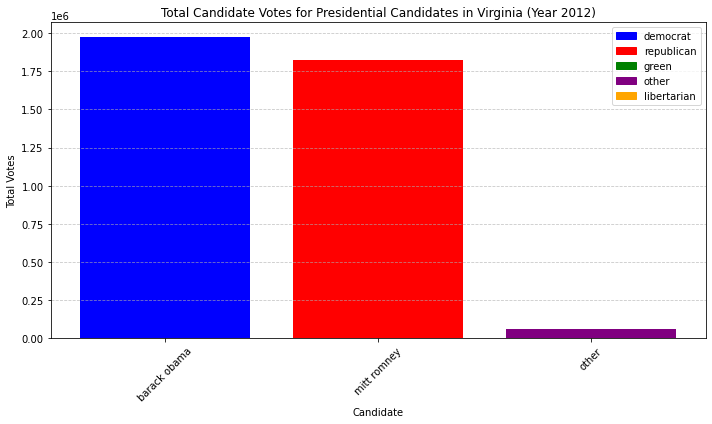

In [82]:
# 2012: Filter the DataFrame for the election year
vdf_2012 = vdf_filtered[vdf_filtered['year'] == 2012]
total_candidate_votes = vdf_2012.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2012)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [83]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2012
vdf_2012 = vdf_filtered[vdf_filtered['year'] == 2012]

# Summing up votes per candidate
total_candidate_votes = vdf_2012.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2012 data
candidate_to_party = vdf_2012.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

      candidate  Total Votes       Party
0  barack obama      1971820    democrat
1   mitt romney      1822522  republican
2         other        60147       other


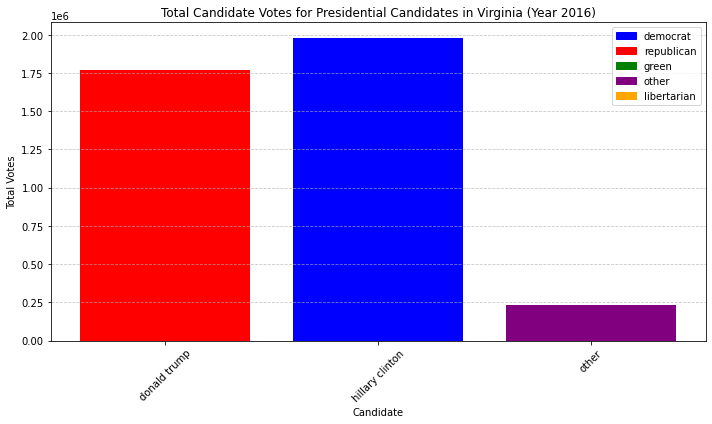

In [23]:
# 2016: Filter the DataFrame for the election year
vdf_2016 = vdf_filtered[vdf_filtered['year'] == 2016]
total_candidate_votes = vdf_2016.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2016)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [79]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2016
vdf_2016 = vdf_filtered[vdf_filtered['year'] == 2016]

# Summing up votes per candidate
total_candidate_votes = vdf_2016.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2016 data
candidate_to_party = vdf_2016.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

         candidate  Total Votes       Party
0     donald trump      1769443  republican
1  hillary clinton      1981473    democrat
2            other       233715       other


This graph and table are particularly more interesting given that Hillary Clinton received more votes than Donald Trump despite Trump's national victory. This shows the significance of the Electoral College system in U.S. elections, where a candidate can win the presidency without getting the majority of the popular vote. This election goes to show that Virginia is a swing state, making it critical in the national election outcomes. 

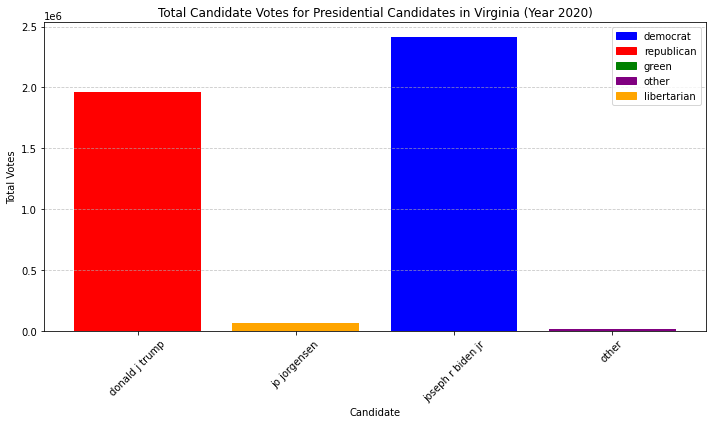

In [80]:
# 2020: Filter the DataFrame for the election year
vdf_2020 = vdf_filtered[vdf_filtered['year'] == 2020]
total_candidate_votes = vdf_2020.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2020)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2020
vdf_2020 = vdf_filtered[vdf_filtered['year'] == 2020]

# Summing up votes per candidate
total_candidate_votes = vdf_2020.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2020 data
candidate_to_party = vdf_2020.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

           candidate  Total Votes        Party
0     donald j trump      1962430   republican
1       jo jorgensen        64761  libertarian
2  joseph r biden jr      2413568     democrat
3              other        21841        other


In [50]:
# Find the county with the largest increase in democratic voters
democratic_votes = df[df['party'] == 'democrat']

democratic_votes = democratic_votes.groupby('county_name').agg(
    democratic_votes_2000=('candidatevotes', lambda x: x[df['year'] == 2000].sum()),
    democratic_votes_2020=('candidatevotes', lambda x: x[df['year'] == 2020].sum())
)

democratic_votes['increase'] = democratic_votes['democratic_votes_2020'] - democratic_votes['democratic_votes_2000']

county_with_largest_increase = democratic_votes['increase'].idxmax()
largest_increase = democratic_votes.loc[county_with_largest_increase, 'increase']

print(f"The county with the largest increase in Democratic votes from 2000 to 2020 is {county_with_largest_increase} with an increase of {largest_increase} votes.")
     

The county with the largest increase in Democratic votes from 2000 to 2020 is fairfax with an increase of 219081 votes.


In [51]:
# Find the county with the lowest rate of change or a decrease in democratic voters
democratic_votes['change'] = democratic_votes['democratic_votes_2020'] - democratic_votes['democratic_votes_2000']

county_with_lowest_change = democratic_votes['change'].idxmin()
lowest_change = democratic_votes.loc[county_with_lowest_change, 'change']

print(f"The county with the lowest rate of change or a decrease in Democratic votes from 2000 to 2020 is {county_with_lowest_change} with a change of {lowest_change} votes.")
     

The county with the lowest rate of change or a decrease in Democratic votes from 2000 to 2020 is virginia beach with a change of -62268 votes.


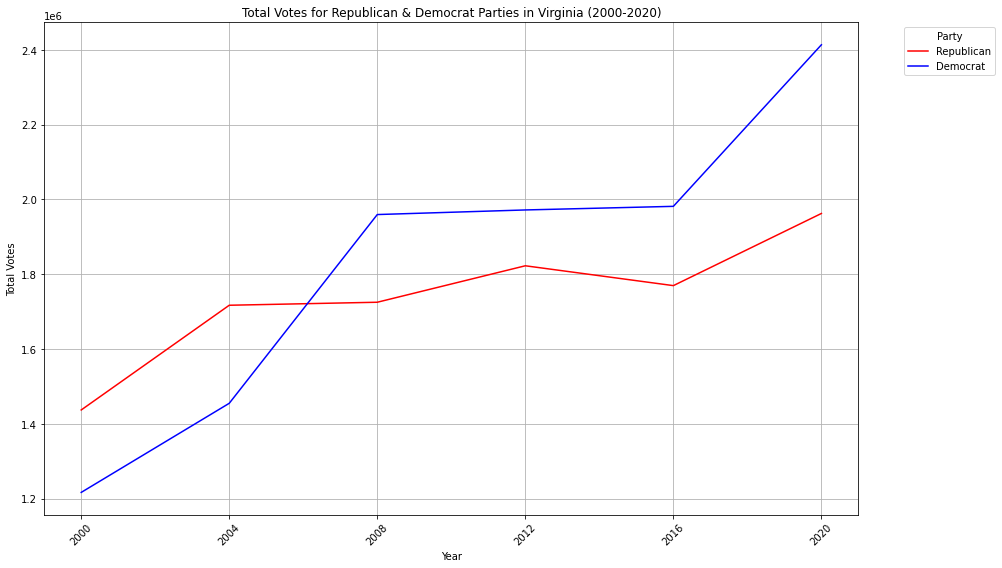

In [28]:
# Filter for only Republican and Democratic parties
total_votes_over_time = vdf_filtered[
    vdf_filtered['party'].isin(['republican', 'democrat'])
].groupby(['year', 'party'])['candidatevotes'].sum().reset_index()

# Prepare the plot
plt.figure(figsize=(14, 8))

# Color map for Republican and Democrat
color_map = {
    'democrat': 'blue',
    'republican': 'red'
}

# Plot each party's vote trajectory
for party in ['republican', 'democrat']:
    party_data = total_votes_over_time[total_votes_over_time['party'] == party]
    plt.plot(party_data['year'], party_data['candidatevotes'], label=party.capitalize(), color=color_map[party])

# Adding labels and legend
plt.title('Total Votes for Republican & Democrat Parties in Virginia (2000-2020)')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.xticks(total_votes_over_time['year'].unique(), rotation=45)  # Ensure all years are shown
plt.grid(True)
plt.legend(title='Party', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Show the plot
plt.show()


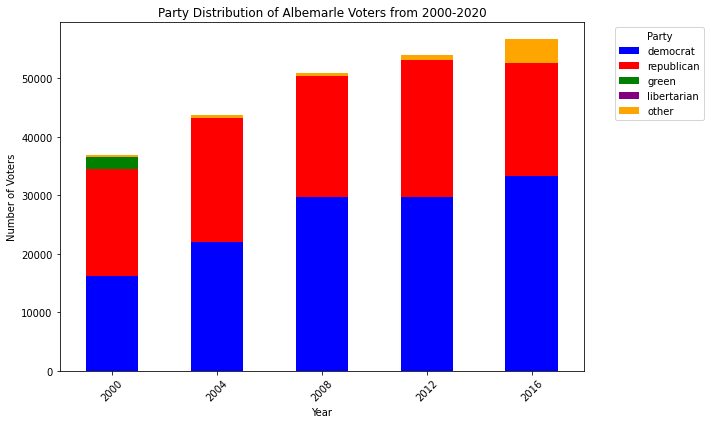

In [31]:
pivot_df = albemarledf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

pivot_df.plot(kind='bar', stacked=True, color=party_colors.values(), figsize=(10, 6))

plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_24130/701391385.py:11: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)


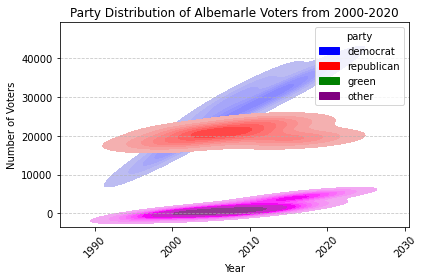

In [52]:
# Showing party distribution of Albemarle voters over time
albemarledf = vdf_filtered[(vdf_filtered['county_name'] == 'albemarle') & (vdf_filtered['year'].isin(range(2000,2020)))]

party_colors = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}
sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)
plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel("Year")
plt.ylabel("Number of Voters")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

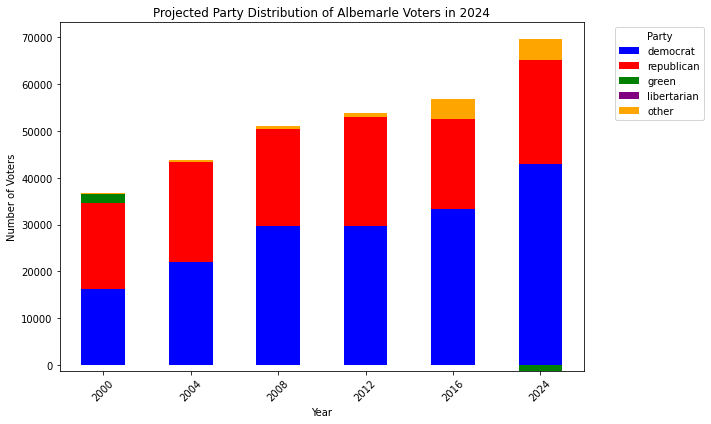

In [54]:
#Predicting 2024 voting outcome for Albemarle county (us!)
albemarledf = vdf_filtered[(vdf_filtered['county_name'] == 'albemarle') & (vdf_filtered['year'].isin(range(2000,2020)))]
pivot_df = albemarledf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Albemarle Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

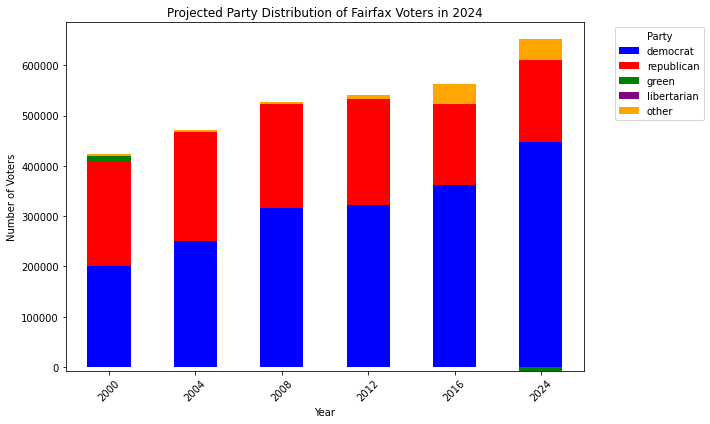

In [55]:
# Predicting 2024 voting outcome for Fairfax county (us!)
fairfaxdf = vdf_filtered[(vdf_filtered['county_name'] == 'fairfax') & (vdf_filtered['year'].isin(range(2000,2020)))]
pivot_df = fairfaxdf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Fairfax Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

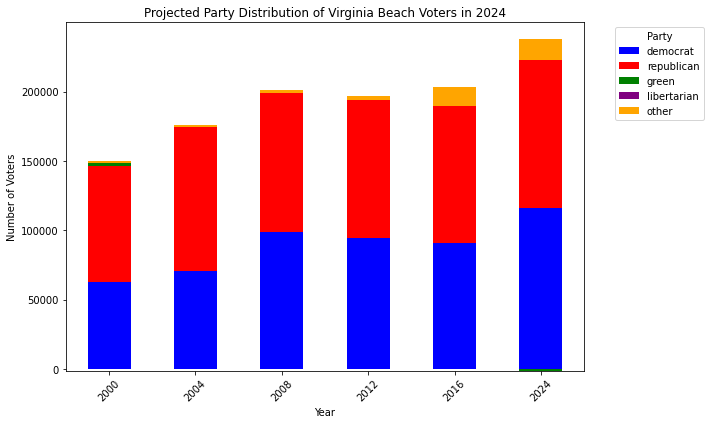

In [57]:
#Predicting 2024 voting outcome for Virginia Beach county (us!)
vabeachdf = vdf_filtered[(vdf_filtered['county_name'] == 'virginia beach') & (vdf_filtered['year'].isin(range(2000,2020)))]
pivot_df = vabeachdf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Virginia Beach Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
     

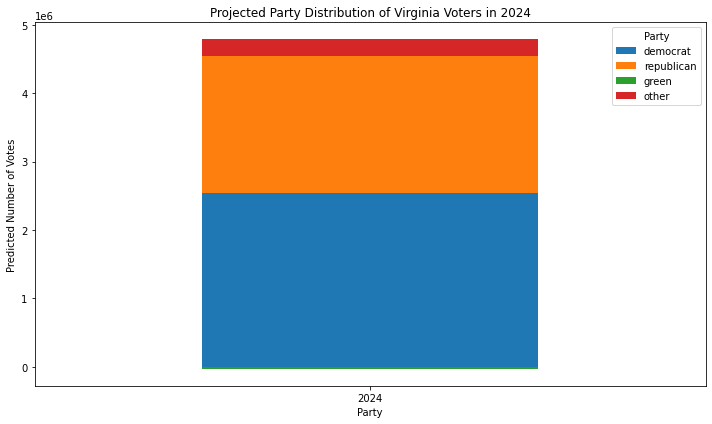

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming vdf_filtered is already prepared and contains the needed data
statewide_df = vdf_filtered[vdf_filtered['year'].isin(range(2000,2020))].groupby(['year', 'party'])['candidatevotes'].sum().unstack(fill_value=0)
column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
statewide_df = statewide_df.reindex(columns=column_order)

predictions = {}
for party in statewide_df.columns:
    X = statewide_df.index.values.reshape(-1, 1)  # Year
    y = statewide_df[party].values.reshape(-1, 1)  # Votes

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

# Plot only the predictions for 2024
prediction_df = pd.DataFrame(predictions, index=[2024])
prediction_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Projected Party Distribution of Virginia Voters in 2024')
plt.xlabel('Party')
plt.ylabel('Predicted Number of Votes')
plt.xticks(rotation=0)
plt.legend(title='Party', loc='upper right')
plt.tight_layout()
plt.show()


In [64]:
# Print out predictions as text
total_votes = sum(predictions.values())
print("Predicted Number of Votes for Virginia in 2024 by Party:")
for party, votes in predictions.items():
    print(f"{party.title()}: {int(votes):,} votes ({votes/total_votes:.2%} of total)")

Predicted Number of Votes for Virginia in 2024 by Party:
Democrat: 2,535,669 votes (53.28% of total)
Republican: 2,002,439 votes (42.07% of total)
Green: -35,623 votes (-0.75% of total)
Other: 257,068 votes (5.40% of total)
